In [4]:
# working model with basic features from application_train and previous applications
# Added actual and expected EAR from previous applications

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.filterwarnings('ignore')

/anaconda3/envs/nlp/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [6]:
print('Importing data...')
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
previous_ear = pd.read_csv('actual_expected_ear.csv')

Importing data...


In [7]:
previous_ear.head(5)

,SK_ID_CURR,MEAN_ACTUAL_EAR,MEDIAN_ACTUAL_EAR,STD_ACTUAL_EAR,MEAN_EXPECTED_EAR,MEDIAN_EXPECTED_EAR,STD_EXPECTED_EAR
0,100001,0.272618,0.272618,0.00000,1.199400,1.199400,0.000000
1,100002,0.256557,0.256557,0.00000,0.238453,0.238453,0.000000
2,100003,0.398378,0.401412,0.10681,0.368710,0.385640,0.083249
3,100004,0.405439,0.405439,0.00000,0.360515,0.360515,0.000000
4,100005,-1.000000,-1.000000,0.00000,0.516463,0.516463,0.730389


# <a id=1 > 1. Processing test and train dataset </a>

In [8]:
target = train['TARGET']
del train['TARGET']

In [9]:
data = pd.concat([train,test])

In [10]:
data.shape, train.shape, test.shape

((356255, 121), (307511, 121), (48744, 121))

In [11]:
docs = [col for col in data.columns if 'FLAG_DOC' in col]
# Flag_document features - count and kurtosis
data['DOCUMENT_COUNT'] = data[docs].sum(axis=1)
data['NEW_DOC_KURT'] = data[docs].kurtosis(axis=1)  #long tails

In [12]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [13]:
# Categorical age - based on target=1 plot
data['AGE_RANGE'] = data['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

In [14]:
# New features based on External sources
data['EXT_SOURCES_PROD'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
data['EXT_SOURCES_WEIGHTED'] = data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 1 + data.EXT_SOURCE_3 * 3
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        data[feature_name] = eval('np.{}'.format(function_name))(
            data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [15]:
# Credit ratios
data['CREDIT_TO_ANNUITY_RATIO'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['CREDIT_TO_GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']

In [16]:
# Income ratios
data['ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['INCOME_TO_EMPLOYED_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_EMPLOYED']
data['INCOME_TO_BIRTH_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_BIRTH']
data['INCOME_TO_CREDIT_RATION'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']

In [17]:
# Time ratios
data['EMPLOYED_TO_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['ID_TO_BIRTH_RATIO'] = data['DAYS_ID_PUBLISH'] / data['DAYS_BIRTH']
data['CAR_TO_BIRTH_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
data['CAR_TO_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
data['PHONE_TO_BIRTH_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']

In [18]:
# Join data with expected EAR
data = data.merge(previous_ear, on='SK_ID_CURR', how='left')

In [19]:
data.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,MEAN_ACTUAL_EAR,MEDIAN_ACTUAL_EAR,STD_ACTUAL_EAR,MEAN_EXPECTED_EAR,MEDIAN_EXPECTED_EAR,STD_EXPECTED_EAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.224078,NaN,NaN,0.119860,0.256557,0.256557,0.000000,0.238453,0.238453,0.000000
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.017358,NaN,NaN,0.049389,0.398378,0.401412,0.106810,0.368710,0.385640,0.083249
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.132889,-0.001365,-0.115556,0.042791,0.405439,0.405439,0.000000,0.360515,0.360515,0.000000
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0.128229,NaN,NaN,0.032465,0.578911,0.199462,1.798905,0.282858,0.342949,0.294920
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.173490,NaN,NaN,0.055489,0.212948,0.641118,0.893287,0.690733,0.618032,0.232068


In [20]:
# differences in expected and Actual EAR
data['DIFFERENCE_MEAN_EAR'] = data['MEAN_EXPECTED_EAR'] - data['MEAN_ACTUAL_EAR']
data['DIFFERENCE_MEDIAN_EAR'] = data['MEAN_EXPECTED_EAR'] - data['MEDIAN_ACTUAL_EAR']

In [21]:
data.head(6)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,MEAN_ACTUAL_EAR,MEDIAN_ACTUAL_EAR,STD_ACTUAL_EAR,MEAN_EXPECTED_EAR,MEDIAN_EXPECTED_EAR,STD_EXPECTED_EAR,DIFFERENCE_MEAN_EAR,DIFFERENCE_MEDIAN_EAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,NaN,0.119860,0.256557,0.256557,0.000000,0.238453,0.238453,0.000000,-0.018103,-0.018103
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,0.049389,0.398378,0.401412,0.106810,0.368710,0.385640,0.083249,-0.029668,-0.032702
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,-0.115556,0.042791,0.405439,0.405439,0.000000,0.360515,0.360515,0.000000,-0.044924,-0.044924
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,0.032465,0.578911,0.199462,1.798905,0.282858,0.342949,0.294920,-0.296053,0.083397
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,0.055489,0.212948,0.641118,0.893287,0.690733,0.618032,0.232068,0.477785,0.049615
5,100008,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,NaN,0.149696,0.608476,0.397923,0.522351,0.365353,0.262448,0.342714,-0.243123,-0.032571


In [22]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [23]:
# Groupby: Statistics for applications in the same group
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
data = do_median(data, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
data = do_std(data, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
data = do_mean(data, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
data = do_std(data, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
data = do_mean(data, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
data = do_std(data, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
data = do_mean(data, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
data = do_mean(data, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
data = do_std(data, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')
data = do_mean(data, group, 'MEAN_EXPECTED_EAR', 'GROUP_MEAN_EXPECTED_EAR')
data = do_median(data, group, 'MEDIAN_EXPECTED_EAR', 'GROUP_MEDIAN_EXPECTED_EAR')
data = do_mean(data, group, 'STD_EXPECTED_EAR', 'GROUP_STD_EXPECTED_EAR')
data = do_mean(data, group, 'MEAN_ACTUAL_EAR', 'GROUP_MEAN_ACTUAL_EAR')
data = do_median(data, group, 'MEDIAN_ACTUAL_EAR', 'GROUP_MEDIAN_ACTUAL_EAR')
data = do_mean(data, group, 'STD_ACTUAL_EAR', 'GROUP_STD_ACTUAL_EAR')

In [24]:
data.head(6)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,GROUP_CREDIT_TO_ANNUITY_STD,GROUP_CREDIT_MEAN,GROUP_ANNUITY_MEAN,GROUP_ANNUITY_STD,GROUP_MEAN_EXPECTED_EAR,GROUP_MEDIAN_EXPECTED_EAR,GROUP_STD_EXPECTED_EAR,GROUP_MEAN_ACTUAL_EAR,GROUP_MEDIAN_ACTUAL_EAR,GROUP_STD_ACTUAL_EAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,6.189382,423946.077897,24847.926485,12190.206798,0.485687,0.425466,0.255542,1.731396,0.381520,2.998243
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,8.206111,717295.519651,29831.965939,15037.721692,0.419197,0.344274,0.241606,3.447678,0.352478,5.889898
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,7.567490,627030.309524,27408.857143,13448.587113,0.414061,0.346106,0.256650,0.970870,0.419042,1.413925
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,7.737152,602336.162211,26623.157514,12942.189239,0.398109,0.342894,0.255653,0.788642,0.341441,1.321883
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,8.789658,904500.000000,28931.625000,10551.123924,0.468061,0.441016,0.227216,0.217052,0.470301,0.808600
5,100008,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,7.575709,603509.384348,28091.903478,13009.232136,0.476706,0.414426,0.274849,0.996204,0.434492,1.737987


In [25]:
# one-hot encoding
categorical_features = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data, columns=categorical_features)

In [26]:
data.shape

(356255, 291)

In [27]:
#Pre-processing previous_application
print('Pre-processing previous_application...')
prev = pd.read_csv('previous_application.csv')
prev_cat_features = [pcol for pcol in prev.columns if prev[pcol].dtype == 'object']
prev = pd.get_dummies(prev, columns=prev_cat_features)
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['COUNT_PREV_APP'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

Pre-processing previous_application...


In [28]:
data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

In [29]:
data.shape

(356255, 454)

In [30]:
train = data.iloc[:train.shape[0],:]
test = data.iloc[train.shape[0]:,]

In [31]:
data.shape, train.shape, test.shape

((356255, 454), (307511, 454), (48744, 454))

In [32]:
del train['SK_ID_CURR']
del test['SK_ID_CURR']

In [33]:
train_x, valid_x, train_y, valid_y = train_test_split(train, target, test_size=0.2, shuffle=True)

In [34]:
#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

In [35]:
#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }

In [36]:
#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 40,
                 verbose_eval= 10
                 )

Training until validation scores don't improve for 40 rounds.
[10]	valid_0's auc: 0.743054
[20]	valid_0's auc: 0.749096
[30]	valid_0's auc: 0.75403
[40]	valid_0's auc: 0.758665
[50]	valid_0's auc: 0.762628
[60]	valid_0's auc: 0.766071
[70]	valid_0's auc: 0.768802
[80]	valid_0's auc: 0.770529
[90]	valid_0's auc: 0.772318
[100]	valid_0's auc: 0.773543
[110]	valid_0's auc: 0.77457
[120]	valid_0's auc: 0.775545
[130]	valid_0's auc: 0.776177
[140]	valid_0's auc: 0.77701
[150]	valid_0's auc: 0.777595
[160]	valid_0's auc: 0.777979
[170]	valid_0's auc: 0.778273
[180]	valid_0's auc: 0.778649
[190]	valid_0's auc: 0.778957
[200]	valid_0's auc: 0.77934
[210]	valid_0's auc: 0.779558
[220]	valid_0's auc: 0.779663
[230]	valid_0's auc: 0.779698
[240]	valid_0's auc: 0.779726
[250]	valid_0's auc: 0.779722
[260]	valid_0's auc: 0.779863
[270]	valid_0's auc: 0.779801
[280]	valid_0's auc: 0.779851
[290]	valid_0's auc: 0.780043
[300]	valid_0's auc: 0.779996
[310]	valid_0's auc: 0.780045
[320]	valid_0's auc: 

In [37]:
# Confusion matrix
predictions_validy = lgbm.predict(valid_x)
p_validy = np.where(predictions_validy > 0.5, 1, 0)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_y, p_validy)
cm

array([[56332,   123],
       [ 4879,   169]])

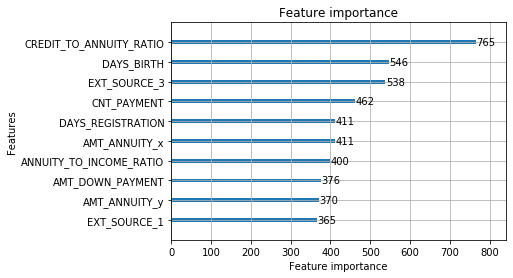

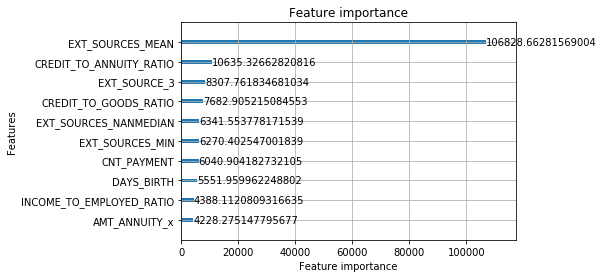

In [38]:
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=10, importance_type='split')
lgb.plot_importance(lgbm, max_num_features=10, importance_type='gain')

In [39]:
predictions_lgbm_prob = lgbm.predict(test)

In [40]:
lgbm_submission = pd.read_csv('sample_submission.csv')

In [41]:
lgbm_submission.TARGET = predictions_lgbm_prob

In [42]:
lgbm_submission.to_csv('lgbm_submission.csv', index=False) #score : 0.774029

data columns

In [43]:
column_info = pd.read_csv('HomeCredit_columns_description.csv', encoding = 'unicode_escape')

In [44]:
column_info[column_info['Table'] == 'previous_application.csv'][:3]

,Unnamed: 0,Table,Row,Description,Special
173,176,previous_application.csv,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
174,177,previous_application.csv,SK_ID_CURR,ID of loan in our sample,hashed
175,178,previous_application.csv,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa...",NaN


In [45]:
test[['MEAN_ACTUAL_EAR', 'MEAN_EXPECTED_EAR']]

,MEAN_ACTUAL_EAR,MEAN_EXPECTED_EAR
307511,0.272618,1.199400
307512,-1.000000,0.516463
307513,0.085821,0.548859
307514,0.216025,0.107648
307515,1.149183,0.757520
307516,0.625341,0.404926
307517,-0.264730,0.311126
307518,0.620921,0.252725
307519,0.271490,0.254882
307520,0.223434,0.358676


In [48]:
(56332+169)/(56332+169+123+4879) * 100

91.86706339528153

In [49]:
(56501+121)/(56501+121+4804+77) * 100

92.06380176576752